In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import trange, tqdm

from robot_utils.robot_data.img_data import ImgData
from robot_utils.robot_data.pose_data import PoseData
from robot_utils.transform import transform, T3d_2_T2d

import sys
sys.path.append("/home/masonbp/ford/fastsam3d")

from segment_track.observation import Observation
from segment_track.segment import Segment
from segment_track.tracker import Tracker
from segment_track.fastsam_wrapper import FastSAMWrapper

from object_map_registration.object.object import Object
from object_map_registration.object.ellipsoid import Ellipsoid
from object_map_registration.register.clipper_pt_registration import ClipperPtRegistration
from object_map_registration.register.dist_vol_sim_reg import DistVolSimReg
from object_map_registration.utils import object_list_bounds

In [2]:
cam_params_pkl = open('/home/masonbp/data/west_point_2023/acl_jackal2_cam_params.pkl', 'rb')
cam_params = pickle.load(cam_params_pkl)
observation_files = [
    '/home/masonbp/results/west_point_2023/segment_observations/1117_04_585_645.pkl',
    '/home/masonbp/results/west_point_2023/segment_observations/1117_02_165_225.pkl',
]
observation_data = [pickle.load(open(f, 'rb')) for f in observation_files]
num_robots = len(observation_data)
assert num_robots <= 2

In [34]:
t0s = [od.t0 for od in observation_data]
tfs = [od.tf for od in observation_data]

In [3]:
sol_pkl = "/home/masonbp/results/west_point_2023/frame_align_investigation/test_09/time_10_30/possible_success/solutions.pickle"
clipper_sol = pickle.load(open(sol_pkl, 'rb'))[0][1]
print(clipper_sol.transform)

[[    0.99832   -0.025989    0.051777     0.64622]
 [   0.031947     0.99253    -0.11778     -5.9884]
 [  -0.048329     0.11924     0.99169     -6.4108]
 [          0           0           0           1]]


In [4]:
trackers = [Tracker(
    camera_params=cam_params,
    pixel_std_dev=10.0,
    min_iou=0.5,
    min_sightings=3,
    max_t_no_sightings=0.25
) for _ in range(num_robots)]

for i in range(num_robots):
    for observations in tqdm(observation_data[i]._data):
        if len(observations) > 0:
            trackers[i].update(observations[0].time, observations)


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1041 [00:00<?, ?it/s]

In [38]:
def keep_fun(segment: Segment, i: int):
    try:
        return segment.num_sightings > 10 \
            and segment.reconstruction3D(width_height=True)[3] > 0.1 \
            and segment.reconstruction3D(width_height=True)[4] > .1 \
            and (i == 1 or segment.last_seen < tfs[0] - 30)
    except:
        return False

for i in range(num_robots):
    print(f"{i} segments: {len(trackers[i].segments)}")
    print(f"{i} segment graveyard: {len(trackers[i].segment_graveyard)}")

filtered_segments = [[s for s in trackers[i].segment_graveyard if keep_fun(s, i)] for i in range(num_robots)]

print()
for i in range(num_robots):
    print(f"{i} filtered segments: {len(filtered_segments[i])}")

0 segments: 6
0 segment graveyard: 569
1 segments: 2
1 segment graveyard: 685

0 filtered segments: 49
1 filtered segments: 73


(27.684390923821567, 61.72700551142233)

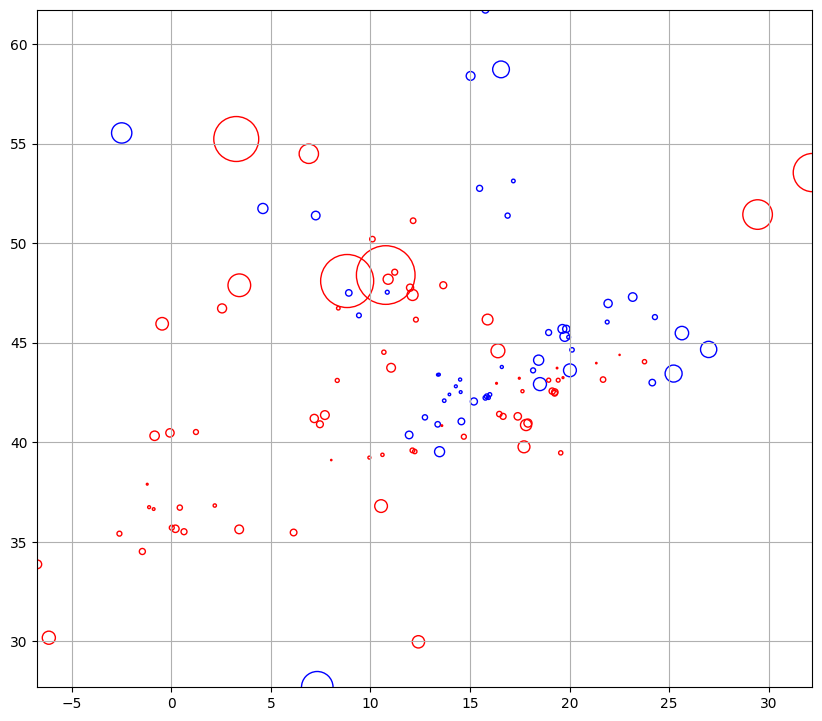

In [62]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
maps = [[], []]

formats = ['bx', 'r+']
colors = ['blue', 'red']

for i in range(num_robots):
    # trackers[i].merge()
    for segment in filtered_segments[i]: #trackers[i].segments + trackers[i].segment_graveyard:
        try:
            if segment.num_sightings < 10: continue
            reconstruction = segment.reconstruction3D(width_height=True)
            # position, width = reconstruction[:2], reconstruction[3]
            # ellipsoid = Ellipsoid(reconstruction[:2], axes=np.array([width/2, width/2]), rot_mat=np.eye(2))
            position, width, height = reconstruction[:3], reconstruction[3], reconstruction[4]
            
            # ellipsoid = Ellipsoid(reconstruction[:3], axes=np.array([width/2, width/2, height/2]), rot_mat=np.eye(3))
            # if i == 0:
            #     ellipsoid.transform(clipper_sol.transform)

            ellipsoid = Ellipsoid(reconstruction[:2], axes=np.array([width/2, width/2]), rot_mat=np.eye(2))
            if i == 0:
                ellipsoid.transform(T3d_2_T2d(clipper_sol.transform))

            maps[i].append(ellipsoid)
            maps[i][-1].plot2d(ax, edgecolor=colors[i])
        except:
            print("missed this one")

maps_bounds = object_list_bounds(maps[0] + maps[1])
ax.set_xlim(maps_bounds[0])
ax.set_ylim(maps_bounds[1])
# print(maps_bounds)

In [63]:
clipper = ClipperPtRegistration(sigma=.2, epsilon=.4)
inliers_cl = clipper.register(maps[0], maps[1])
print(inliers_cl)

[[19 71]
 [35 57]
 [11 65]
 [36 62]
 [10 68]
 [30 51]
 [39 54]
 [37 56]
 [40 55]]


In [74]:
from motlee.realign.frame_aligner import FrameAligner, AssocMethod
frame_aligner = FrameAligner(
    method=AssocMethod.CLIPPER_MULT_SOL,
    clipper_sigma=.2,
    clipper_epsilon=.4,
    clipper_mult_downweight=0.0,
    clipper_mult_repeats=5
)
centroids1 = np.array([ellipsoid.centroid.reshape(-1) for ellipsoid in maps[0]])
centroids2 = np.array([ellipsoid.centroid.reshape(-1) for ellipsoid in maps[1]])
sols = frame_aligner.align_objects(static_objects=[centroids1, centroids2])



In [77]:
map_transformed = []
for obj in maps[1]:
    obj_cp = obj.copy()
    obj_cp.transform(T3d_2_T2d(sols[2].transform))
    map_transformed.append(obj_cp)


In [10]:
# dist_vol_reg = DistVolSimReg(sigma=.2, epsilon=.4, vol_score_min=.5, dist_score_min=.5)
# inliers = dist_vol_reg.register(maps[0], maps[1])
# print(inliers)

[[ 4 72]
 [24 57]
 [52 48]
 [16 51]
 [14 62]
 [41 16]
 [54 36]
 [87 27]
 [ 2  5]
 [42 45]
 [61 19]
 [76 25]
 [83 11]
 [88 58]
 [63 17]
 [ 6 47]
 [19 23]
 [95 37]
 [55 18]
 [ 9 52]]


(27.684390923821567, 61.72700551142233)

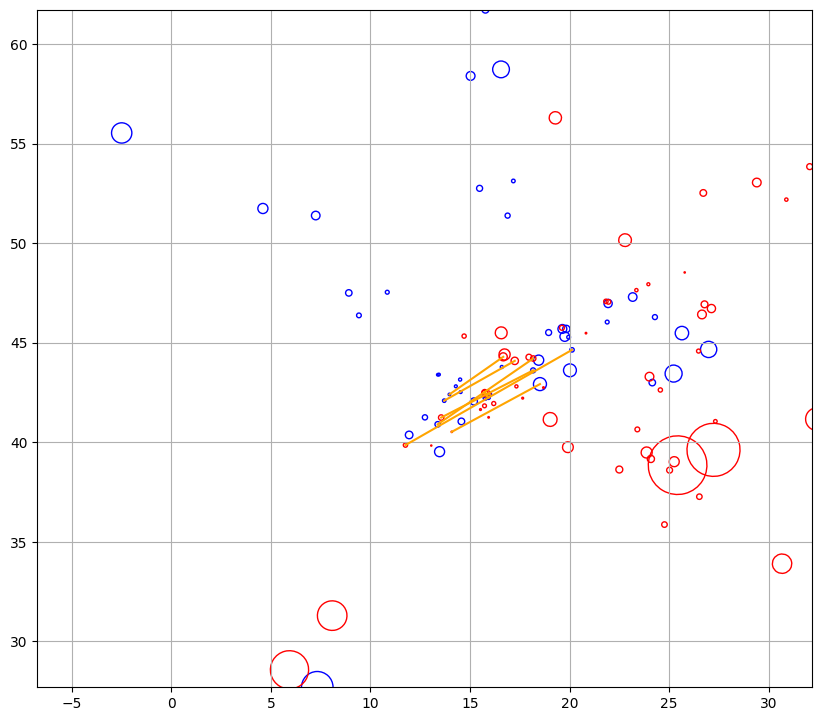

In [78]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
colors = ['blue', 'red']

for obj in maps[0]:
    ax = obj.plot2d(ax, edgecolor=colors[0])
for obj in map_transformed:
    ax = obj.plot2d(ax, edgecolor=colors[1])

# for pair in inliers:
# # for pair in sols[9].associated_objs:
#     ax.plot([maps[0][pair[0]].centroid[0], maps[1][pair[1]].centroid[0]], [maps[0][pair[0]].centroid[1], maps[1][pair[1]].centroid[1]], 'g-', linewidth=3)
# for pair in sols[0].associated_objs:
#     ax.plot([maps[0][pair[0]].centroid[0], maps[1][pair[1]].centroid[0]], [maps[0][pair[0]].centroid[1], maps[1][pair[1]].centroid[1]], color='orange')

for pair in inliers_cl:
    ax.plot([maps[0][pair[0]].centroid[0], map_transformed[pair[1]].centroid[0]], [maps[0][pair[0]].centroid[1], map_transformed[pair[1]].centroid[1]], color='orange')
ax.set_xlim(maps_bounds[0])
ax.set_ylim(maps_bounds[1])
